In [4]:
import json
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from pyawr_utils import awrde_utils
from texttable import Texttable
import skrf as rf



In [5]:
from pyawr_utils import awrde_utils

# 1. Tunable Transmon Coupling parameters

In [6]:
f_q = 4000 # MHz
f_c = 7000 # MHz

g_qc = 200 # MHz


f_cs = np.linspace(5000, 7000, 101) # MHz

deltas = f_cs - f_q
g_eff = g_qc**2/deltas
leakage = np.power(g_qc/deltas, 2)


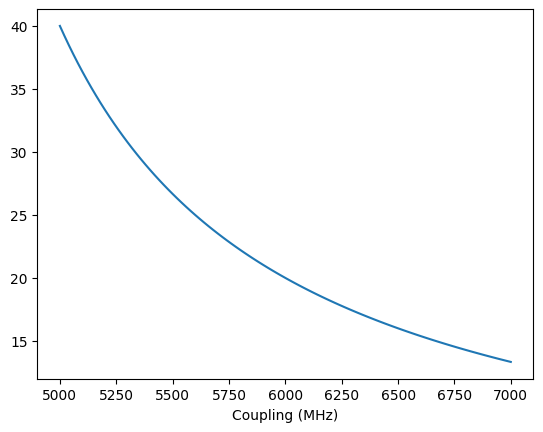

In [7]:
plt.plot(f_cs, g_eff)

plt.xlabel('Frequency (MHz)')
plt.xlabel('Coupling (MHz)')

plt.show()

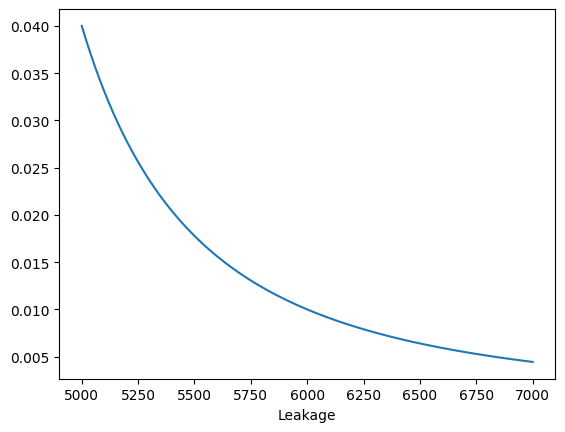

In [8]:
plt.plot(f_cs, leakage)

plt.xlabel('Frequency (MHz)')
plt.xlabel('Leakage')

plt.show()

# 2. Extract Coupling from MWO

### 2.1 Extract Admittance from MWO

In [9]:
awrde = awrde_utils.establish_link()   #Establish link between Python and AWRDE
project = awrde_utils.Project(awrde)    #Assign object variable to Project class
#
project_name = project.project_name      #Get name of currently open project

expected_project_name = '8Q_triangle_lattice_V2_capacitive_coupling.emp'
try:
    assert project_name == expected_project_name
except:
    print(f'Need to open correct project. Got {project_name}, expected {expected_project_name}')
    raise RuntimeError
else:
    print(f'Opened project: {project_name}')
    
project.simulate_analyze()


Opened project: 8Q_triangle_lattice_V2_capacitive_coupling.emp


True

In [288]:
global_def_dict = project.global_definitions_dict
print(global_def_dict)

global_def = global_def_dict['Global Definitions']

equations_dict = global_def.equations_dict
print(equations_dict)

for equation in equations_dict.values():
    print(equation.expression)
    print(equation.equation_value)
    print()
    

{'Global Definitions': <pyawr_utils.misc_utils._GlobalDefinition object at 0x0000021696066890>}
{0: <pyawr_utils.common_utils._Equation object at 0x0000021696067CA0>, 1: <pyawr_utils.common_utils._Equation object at 0x0000021696134F10>, 2: <pyawr_utils.common_utils._Equation object at 0x0000021686044370>, 3: <pyawr_utils.common_utils._Equation object at 0x0000021696065E70>, 4: <pyawr_utils.common_utils._Equation object at 0x0000021696067070>, 5: <pyawr_utils.common_utils._Equation object at 0x0000021696065840>, 6: <pyawr_utils.common_utils._Equation object at 0x0000021696064DC0>, 7: <pyawr_utils.common_utils._Equation object at 0x0000021696065F90>, 8: <pyawr_utils.common_utils._Equation object at 0x0000021696065FF0>, 9: <pyawr_utils.common_utils._Equation object at 0x0000021696066D10>, 10: <pyawr_utils.common_utils._Equation object at 0x0000021696067460>}
Z_0 = 50
W_CPW = 13
S_CPW = 5.44
h_planck = 6.626e-34
e_charge = 1.602e-19
50
W_CPW

f_q = 4000000000.0
4000000000.0

L_c = 1/(C_c *

In [289]:
def extract_admittance_traces(graph_names_to_extract=None, plot_admittance=False):
    
    name_to_frequencies = {}
    name_to_admittance_trace = {}
    
    if graph_names_to_extract is None:
        graph_names_to_extract = ['Y_q', 'Y_c', 'Y_qc', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far']
    
    graphs_dict = project.graph_dict  

    for graph_name in graph_names_to_extract:

        graph = graphs_dict[graph_name]        

        meas_dict = graph.measurements_dict
        meas = meas_dict[0]         

        trace_data_list = meas_dict[0].trace_data 
        trace_data = trace_data_list[0]

        frequencies = trace_data[:,0]
        admittance = trace_data[:,1]*1j

        name_to_frequencies[graph_name] = frequencies
        name_to_admittance_trace[graph_name] = admittance

        if plot_admittance:
            plt.plot(frequencies, admittance.imag, label=f'{meas.measurement_name}')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Admittance')
            plt.legend()
            plt.title(graph_name)
            plt.show() 


    return name_to_frequencies, name_to_admittance_trace

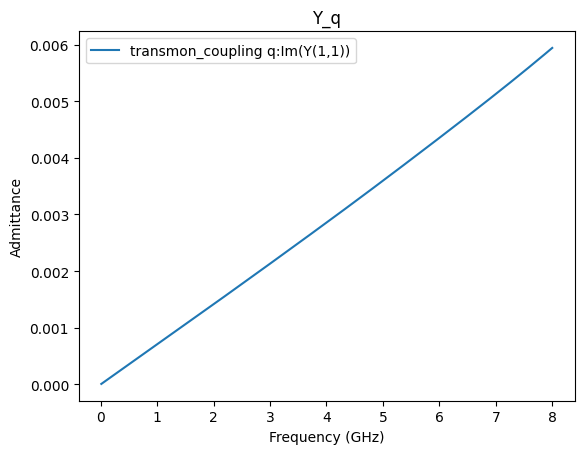

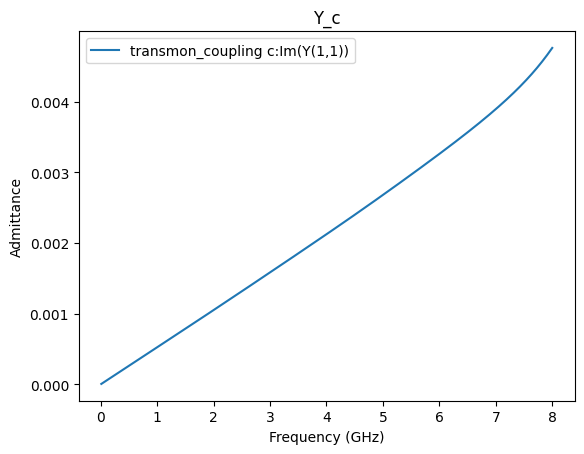

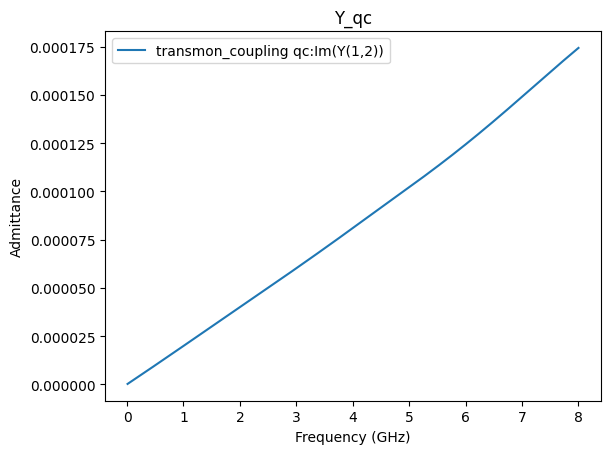

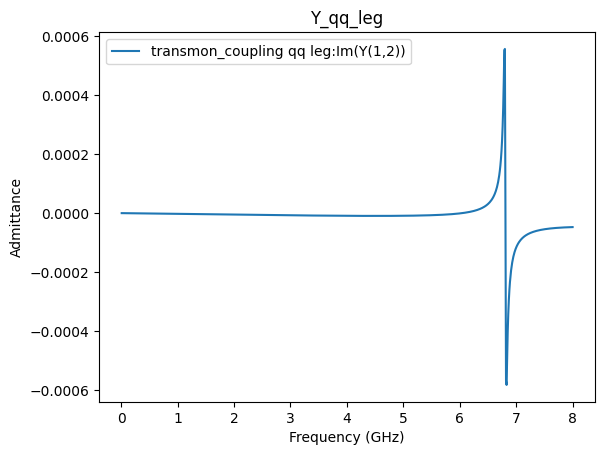

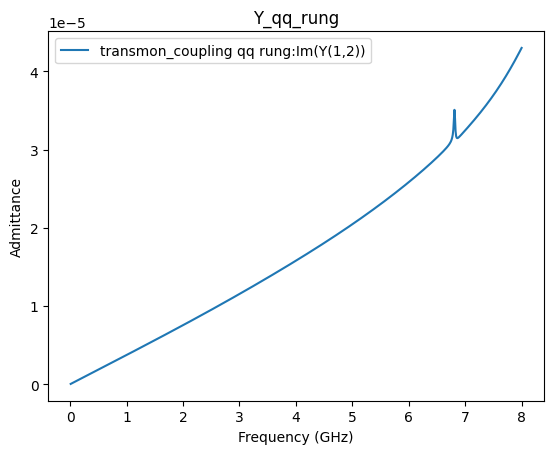

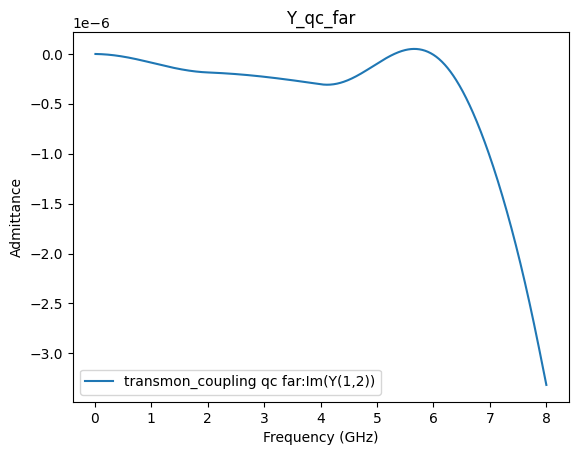

In [290]:
graph_names_to_extract = ['Y_q', 'Y_c', 'Y_qc', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far']

name_to_frequencies, name_to_admittance_trace = extract_admittance_traces(graph_names_to_extract=graph_names_to_extract, plot_admittance=True)



### 2.2 Fit Admittance to pole model

In [291]:
name_to_model_function = {}
name_to_prop_coeff = {}

RMS error = 4.447261840355699e-05


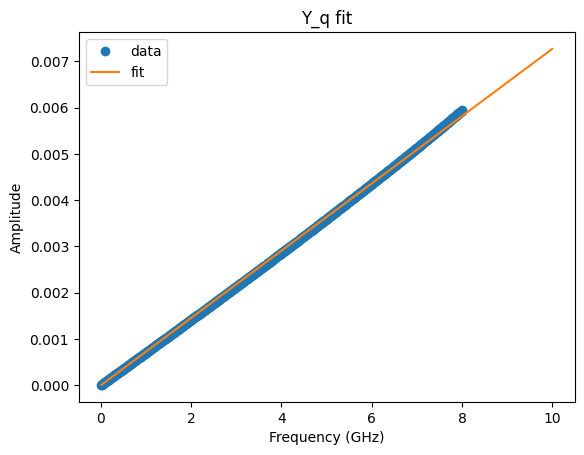

RMS error = 8.356362559707948e-05


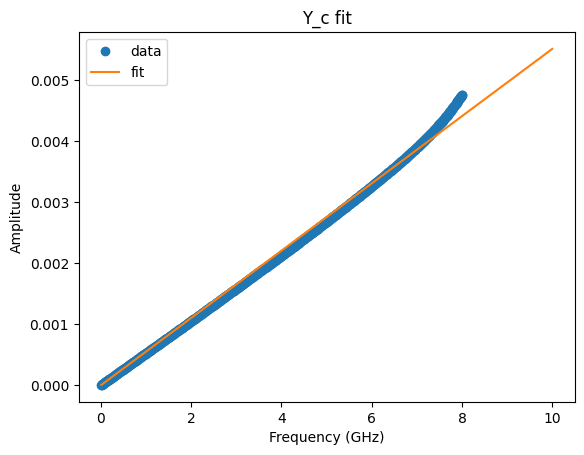

RMS error = 2.0230186550392057e-07


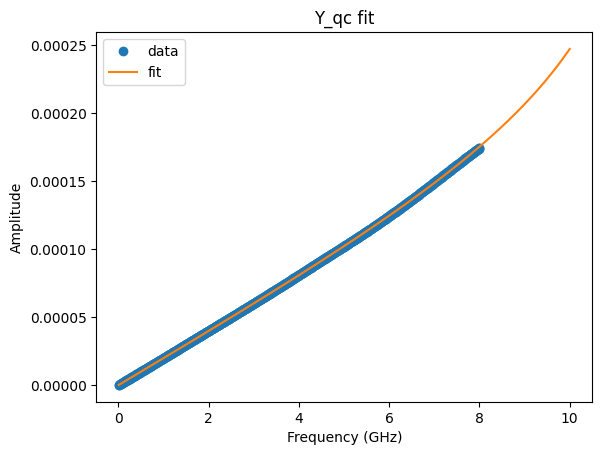

RMS error = 4.424201198150755e-05


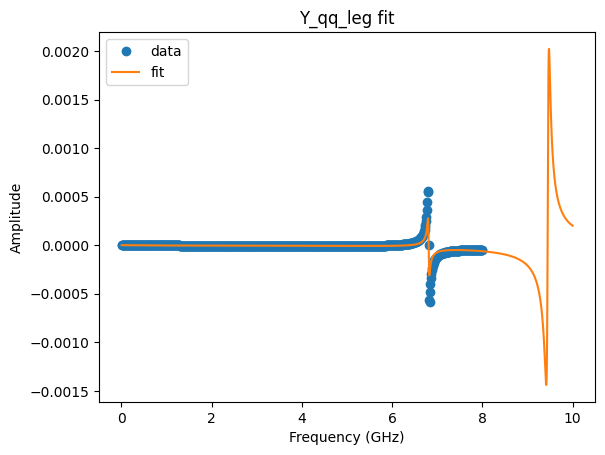

C:\Users\mattm\AppData\Local\Temp\ipykernel_2120\2282098418.py:43: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
  vector_fit.vector_fit(n_poles_real=name_to_num_real_poles[name], n_poles_cmplx=name_to_num_complex_poles[name], parameter_type='y', fit_constant=False, fit_proportional=True)


RMS error = 1.681966423664168e-07


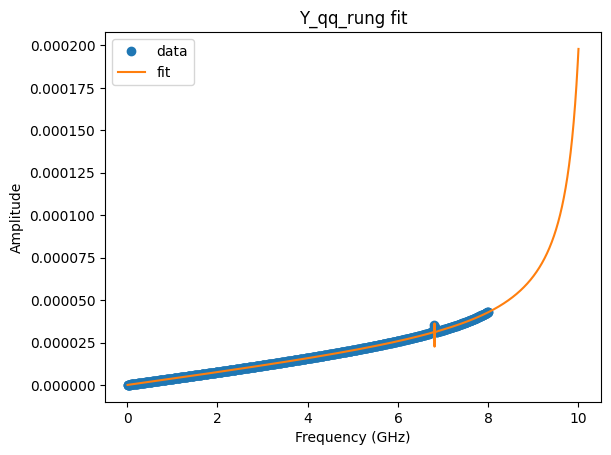

RMS error = 2.0624536168915426e-07


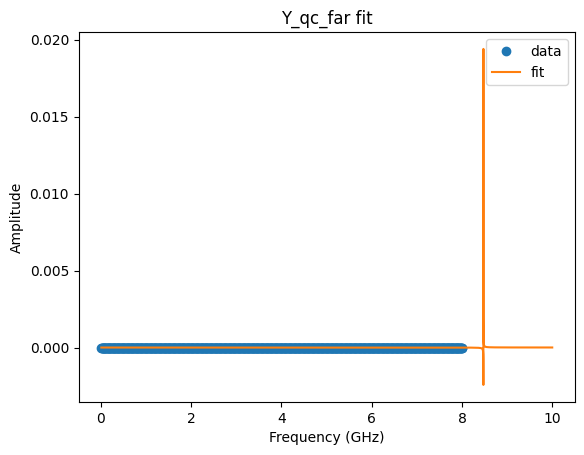

Y_q: 4.447261840355699e-05
Y_c: 8.356362559707948e-05
Y_qc: 2.0230186550392057e-07
Y_qq_leg: 4.424201198150755e-05
Y_qq_rung: 1.681966423664168e-07
Y_qc_far: 2.0624536168915426e-07


In [292]:
# names_to_fit = ['Y_q', 'Y_c', 'Y_qc', 'Y_qc_through_mode', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far']
names_to_fit = ['Y_q', 'Y_c', 'Y_qc', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far']

# names_to_fit = ['Y_qq_rung','Y_qq_leg']
# names_to_fit = ['Y_qc_far']


name_to_num_complex_poles = {'Y_q': 0,
                             'Y_c': 0,
                             'Y_qc': 1,
                             'Y_qq_leg': 3,
                             'Y_qq_rung': 2,
                             'Y_qc_far': 1}

name_to_num_real_poles = {'Y_q': 0,
                          'Y_c': 0,
                          'Y_qc': 0,
                          'Y_qq_leg': 1,
                          'Y_qq_rung': 0,
                          'Y_qc_far': 0}

# name_to_num_complex_poles = {'Y_q': 2,
#                              'Y_c': 2,
#                              'Y_qc': 2,
#                              'Y_qc_through_mode': 1,
#                              'Y_qq_leg': 2,
#                              'Y_qq_rung': 2,
#                              'Y_qc_far': 1}

name_to_rms_error = {}

for name in names_to_fit:
    frequencies = name_to_frequencies[name]
    admittance = name_to_admittance_trace[name]
    
    admittance_reshaped = np.reshape(admittance, (len(admittance), 1, 1))
    
    frequencies_Hz = frequencies * 1e9
    network = rf.Network(frequency=frequencies_Hz, y=admittance_reshaped)
    
    vector_fit = rf.VectorFitting(network)
    
    vector_fit.vector_fit(n_poles_real=name_to_num_real_poles[name], n_poles_cmplx=name_to_num_complex_poles[name], parameter_type='y', fit_constant=False, fit_proportional=True)
#     vector_fit.plot_convergence()
#     plt.show()

#     vector_fit.auto_fit(n_poles_init_real=0, n_poles_init_cmplx=1, n_poles_add=1, model_order_max=4, parameter_type='y')
#     vector_fit.plot_convergence()

    rms_error = vector_fit.get_rms_error(0, 0, parameter_type="y")
    name_to_rms_error[name] = rms_error
    print(f'RMS error = {rms_error}')
    
    
#     print(f'C: {vector_fit.proportional_coeff}')
    
    model_frequencies = np.linspace(0.01e9, 10e9, 10001)
    
    def create_model_function_lambda(_vector_fit):
        return lambda frequency: _vector_fit.get_model_response(0, 0, frequency)

    name_to_model_function[name] = create_model_function_lambda(vector_fit)
    
    name_to_prop_coeff[name] = vector_fit.proportional_coeff
    


    # Y11
    model_y = vector_fit.get_model_response(0, 0, model_frequencies)
    plt.plot(frequencies, admittance.imag, linestyle='', marker='o', label='data')
    plt.plot(model_frequencies/1e9, model_y.imag, label='fit')

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Amplitude')

    plt.legend()

    plt.title(f'{name} fit')
    
#     plt.ylim(-1e-4, 1e-5)
#     plt.xlim(3.9, 4.1)
    
    plt.show()
    
for name in name_to_rms_error:
    print(f'{name}: {name_to_rms_error[name]}')


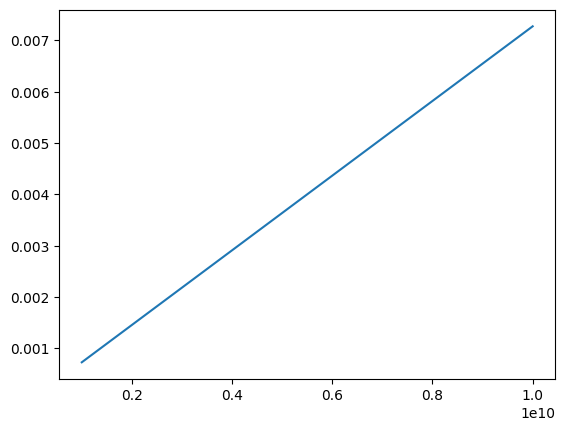

In [293]:
frequencies = np.linspace(1e9, 10e9, 1001)

plt.plot(frequencies, name_to_model_function['Y_q'](frequencies).imag)

### 2.3 Extract Couplings

In [294]:
C_q = name_to_prop_coeff['Y_q'][0]
C_c = name_to_prop_coeff['Y_c'][0]

print(C_q)
print(C_c)

1.1570615285971778e-13
8.761915095208353e-14


In [295]:
Y_q_model_function = name_to_model_function['Y_q']
Y_c_model_function = name_to_model_function['Y_c']
Y_qc_model_function = name_to_model_function['Y_qc']
Y_qq_leg_model_function = name_to_model_function['Y_qq_leg']
Y_qq_rung_model_function = name_to_model_function['Y_qq_rung']
Y_qc_far_model_function = name_to_model_function['Y_qc_far']



# check slope
# freq_1 = 100e6
# freq_2 = 200e6
# freqs = np.linspace(0, 1e9, 1001)
# plt.plot(freqs, Y_q_model_function(freqs).imag)
# plt.show()

# print((Y_q_model_function(freq_2).imag - Y_q_model_function(freq_1).imag)/(freq_2-freq_1)/2/np.pi)



In [296]:
f_q = 4e9 # MHz
f_c = 5.3e9  # MHz

# f_q = 4 # MHz
# f_c = 7  # MHz

g_qc = 1/4*np.sqrt(f_q*f_c/C_q/C_c)*(Y_qc_model_function(f_q).imag/f_q + Y_qc_model_function(f_c).imag/f_c)/1e6/2/np.pi # MHz
print(f'Qubit-Coupler bare coupling: {np.round(g_qc, 2)} MHz')


g_qq_leg = 1/2/C_q*Y_qq_leg_model_function(f_q).imag/1e6/2/np.pi # MHz
print(f'Qubit-Qubit effective coupling along leg: {np.round(g_qq_leg, 2)} MHz')

g_qq_rung = 1/2/C_q*Y_qq_rung_model_function(f_q).imag/1e6/2/np.pi # MHz
print(f'Qubit-Qubit coupling along rung: {np.round(g_qq_rung, 2)} MHz')

g_qc_far = 1/4*np.sqrt(f_q*f_c/C_q/C_c)*(Y_qc_far_model_function(f_q).imag/f_q + Y_qc_far_model_function(f_c).imag/f_c)/1e6/2/np.pi # MHz
print(f'Qubit-Coupler bare coupling on opposite sides: {np.round(g_qc_far, 2)} MHz')


Qubit-Coupler bare coupling: 74.15 MHz
Qubit-Qubit effective coupling along leg: -4.06 MHz
Qubit-Qubit coupling along rung: 10.86 MHz
Qubit-Coupler bare coupling on opposite sides: -0.12 MHz


In [297]:
print(Y_qq_rung_model_function(f_q).imag)

1.578529493416914e-05


### 2.4 Sweep Coupler Frequency

In [298]:
def get_admittance_from_fit(name, frequency):
    return name_to_model_function[name](frequency)

def get_admittance_from_index(frequencies, admittance, frequency):
#     frequencies = name_to_frequencies[name]
#     admittance = name_to_admittance_trace[name]\

    
    
    # number of digits to consider when determining if two floats are equal. i.e. are 5.0031 and 5.003 equal?
    precision_digits = 3
    precision_factor = 10**precision_digits
    
    rounded_frequencies = np.round((frequencies*precision_factor)).astype(np.uint32)
    
#     print(rounded_frequencies)
#     print(int(frequency*precision_factor))
    
    if isinstance(frequency, (np.ndarray, list)):
        indices = []
        for i in range(len(frequency)):
            frequency_i = frequency[i]
            index = np.where(rounded_frequencies == round(frequency_i*precision_factor))[0][0]
            indices.append(index)
        return admittance[indices]
    elif isinstance(frequency, (int, float)):
        index = np.where(rounded_frequencies == round(frequency*precision_factor))[0][0]
    
        return admittance[index]
    
   

In [299]:
def linear_model(x, a, b):
    return a*x + b

In [300]:
def extract_capacitance(frequencies, admittance, plot_fit=False):
    
    popt, pcov = curve_fit(linear_model, frequencies, admittance.imag)
    
    if plot_fit:
        plt.plot(frequencies, admittance.imag, linestyle='', marker='o', label='data')
        plt.plot(frequencies, linear_model(frequencies, *popt), label='fit')

        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Admittance')

        plt.legend()
        plt.show()
        
    C = popt[0]/2/np.pi/1e9 # fF
    return C

In [301]:
def set_coupler_frequency_equation(coupler_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_c':
            equation.equation_value = coupler_frequency
            
def set_qubit_frequency_equation(qubit_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_q':
            equation.equation_value = qubit_frequency
            
def set_qubit_capacitance_equation(qubit_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_q':
            equation.equation_value = qubit_capacitance
            
def set_coupler_capacitance_equation(coupler_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_c':
            equation.equation_value = coupler_capacitance

In [302]:
def get_four_points(data_list, round_digits=2):
    '''
    returns the four points of `data_list` and the first and last indices of `coupler_frequencies_lower` and
    `coupler_frequencies_higher`
    '''
    
    four_points = []
    four_points.append(np.round(data_list[0], round_digits))
    four_points.append(np.round(data_list[num_lower_points-1], round_digits))
    four_points.append(np.round(data_list[num_lower_points], round_digits))
    four_points.append(np.round(data_list[-1], round_digits))
    
    return four_points
        

In [349]:
num_lower_points = 16
num_higher_points = 26

coupler_frequencies_lower = np.linspace(2, 3.5, num_lower_points) # GHz
coupler_frequencies_higher = np.linspace(4.5, 7, num_higher_points) # GHz

coupler_frequencies = np.concatenate([coupler_frequencies_lower, coupler_frequencies_higher])


qubit_frequency = 4.0 # GHz

In [350]:
### first find qubit and coupler capacitances and set the equations in mwo global definitions
set_coupler_frequency_equation(coupler_frequencies[0]*1e9)
set_qubit_frequency_equation(qubit_frequency*1e9)
project.simulate_analyze()
name_to_frequencies, name_to_admittance_trace = extract_admittance_traces(graph_names_to_extract=['Y_q', 'Y_c'])

# extract qubit capacitance
Y_q_frequencies = name_to_frequencies['Y_q']
Y_q_admittance = name_to_admittance_trace['Y_q']
cutoff_index = len(Y_q_frequencies)//10
C_q = extract_capacitance(Y_q_frequencies[:cutoff_index], Y_q_admittance[:cutoff_index], plot_fit=False)
print(f'C_q = {C_q} fF')


# extract coupler capacitance
Y_c_frequencies = name_to_frequencies['Y_c']
Y_c_admittance = name_to_admittance_trace['Y_c']
cutoff_index = len(Y_c_frequencies)//10
C_c = extract_capacitance(Y_c_frequencies[:cutoff_index], Y_c_admittance[:cutoff_index], plot_fit=False)
print(f'C_c = {C_c} fF')

# set qubit and coupler capacitance in mwo global definitions
set_qubit_capacitance_equation(C_q)
set_coupler_capacitance_equation(C_c)

C_q = 1.0004193401616045e-13 fF
C_c = 7.876293400074255e-14 fF


In [351]:
all_graph_names = ['Y_q', 'Y_c', 'Y_qc', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far']
coupling_graph_names = ['Y_qc', 'Y_qq_leg', 'Y_qq_rung', 'Y_qc_far', 'Y_qq_far']

EM_filename = 'EM_transmon_coupling 3 2 1'

include_qq_far = True

g_qc_list = []
g_qq_leg_list = []
g_qq_rung_list = []
g_qc_far_list = []
g_qq_far_list = []

# sweep coupler frequency


for i in range(len(coupler_frequencies)):
    coupler_frequency = coupler_frequencies[i]
    coupler_frequency_Hz = coupler_frequency*1e9
    
    # set frequency in MWO global definitions
    print(f'Setting coupler frequency (f_c) to {coupler_frequency_Hz} Hz')
    set_coupler_frequency_equation(coupler_frequency_Hz)
    
    # simulate
    print('Simulating')
    project.simulate_analyze()
    
    # extract admittance traces
    name_to_frequencies, name_to_admittance_trace = extract_admittance_traces(graph_names_to_extract=coupling_graph_names)
    

    
    # define admittance function for each graph using either the vector fitting fit or the index of the frequency
    
    # for now just use the index
    name_to_admittance_function = {}
    
    def create_admittance_lambda_function(_frequencies, _admittance):
        return lambda frequency: get_admittance_from_index(_frequencies, _admittance, frequency)
        
    for name in coupling_graph_names:
        frequencies = name_to_frequencies[name]
        admittance = name_to_admittance_trace[name]
        name_to_admittance_function[name] = create_admittance_lambda_function(frequencies, admittance)
        
        
#     Y_q_model_function = name_to_admittance_function['Y_q']
#     Y_c_model_function = name_to_admittance_function['Y_c']
    Y_qc_model_function = name_to_admittance_function['Y_qc']
    Y_qq_leg_model_function = name_to_admittance_function['Y_qq_leg']
    Y_qq_rung_model_function = name_to_admittance_function['Y_qq_rung']
    Y_qc_far_model_function = name_to_admittance_function['Y_qc_far']
    Y_qq_far_model_function = name_to_admittance_function['Y_qq_far']
    
    
    g_qc = -1/4*np.sqrt(qubit_frequency*coupler_frequency/C_q/C_c)*(Y_qc_model_function(qubit_frequency).imag/qubit_frequency + Y_qc_model_function(coupler_frequency).imag/coupler_frequency)/1e6/2/np.pi # MHz
    g_qc_list.append(g_qc)
    print(f'Qubit-Coupler bare coupling: {np.round(g_qc, 2)} MHz')


    g_qq_leg = -1/2/C_q*Y_qq_leg_model_function(qubit_frequency).imag/1e6/2/np.pi # MHz
    g_qq_leg_list.append(g_qq_leg)
    print(f'Qubit-Qubit effective coupling along leg: {np.round(g_qq_leg, 2)} MHz')

    g_qq_rung = -1/2/C_q*Y_qq_rung_model_function(qubit_frequency).imag/1e6/2/np.pi # MHz
    g_qq_rung_list.append(g_qq_rung)
    print(f'Qubit-Qubit coupling along rung: {np.round(g_qq_rung, 2)} MHz')

    g_qc_far = -1/4*np.sqrt(qubit_frequency*coupler_frequency/C_q/C_c)*(Y_qc_far_model_function(qubit_frequency).imag/qubit_frequency + Y_qc_far_model_function(coupler_frequency).imag/coupler_frequency)/1e6/2/np.pi # MHz
    g_qc_far_list.append(g_qc_far)
    print(f'Qubit-Coupler bare coupling on opposite sides: {np.round(g_qc_far, 2)} MHz')
    
    if include_qq_far:
        g_qq_far = -1/2/C_q*Y_qq_far_model_function(qubit_frequency).imag/1e6/2/np.pi # MHz
        g_qq_far_list.append(g_qq_far)
        print(f'Qubit-Coupler bare coupling on opposite sides: {np.round(g_qq_far, 2)} MHz')

    
    print()
    print() 
    
g_qc_list = np.array(g_qc_list)
g_qq_leg_list = np.array(g_qq_leg_list)
g_qq_rung_list = np.array(g_qq_rung_list)
g_qc_far_list = np.array(g_qc_far_list)
g_qq_far_list = np.array(g_qq_far_list)

Setting coupler frequency (f_c) to 2000000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -75.07 MHz
Qubit-Qubit effective coupling along leg: 13.94 MHz
Qubit-Qubit coupling along rung: -7.3 MHz
Qubit-Coupler bare coupling on opposite sides: 0.03 MHz
Qubit-Coupler bare coupling on opposite sides: -0.29 MHz


Setting coupler frequency (f_c) to 2100000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -76.94 MHz
Qubit-Qubit effective coupling along leg: 14.19 MHz
Qubit-Qubit coupling along rung: -7.29 MHz
Qubit-Coupler bare coupling on opposite sides: 0.03 MHz
Qubit-Coupler bare coupling on opposite sides: -0.3 MHz


Setting coupler frequency (f_c) to 2200000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -78.77 MHz
Qubit-Qubit effective coupling along leg: 14.48 MHz
Qubit-Qubit coupling along rung: -7.29 MHz
Qubit-Coupler bare coupling on opposite sides: 0.03 MHz
Qubit-Coupler bare coupling on opposite sides: -0.3 MHz


Setting coupler frequency (f_c) to 2300000000.0 Hz
Simulating
Qubit

Simulating
Qubit-Coupler bare coupling: -128.22 MHz
Qubit-Qubit effective coupling along leg: 0.63 MHz
Qubit-Qubit coupling along rung: -7.34 MHz
Qubit-Coupler bare coupling on opposite sides: -0.0 MHz
Qubit-Coupler bare coupling on opposite sides: -0.28 MHz


Setting coupler frequency (f_c) to 5700000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -129.5 MHz
Qubit-Qubit effective coupling along leg: 1.04 MHz
Qubit-Qubit coupling along rung: -7.34 MHz
Qubit-Coupler bare coupling on opposite sides: -0.0 MHz
Qubit-Coupler bare coupling on opposite sides: -0.28 MHz


Setting coupler frequency (f_c) to 5800000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -130.77 MHz
Qubit-Qubit effective coupling along leg: 1.4 MHz
Qubit-Qubit coupling along rung: -7.33 MHz
Qubit-Coupler bare coupling on opposite sides: -0.01 MHz
Qubit-Coupler bare coupling on opposite sides: -0.28 MHz


Setting coupler frequency (f_c) to 5900000000.0 Hz
Simulating
Qubit-Coupler bare coupling: -132.04 MHz
Qubit-Qubit e

In [352]:
detuning = (coupler_frequencies - qubit_frequency)*1e3 # MHz

leakage_list = np.power(g_qc_list/detuning, 2)

tunable_to_fixed_ratio = g_qq_leg_list/g_qq_rung_list

# g_squared_over_delta_list = -np.power(g_qc, 2)/detuning*(np.power(qubit_frequency/coupler_frequencies, 2))
g_squared_over_delta_list = -np.power(g_qc_list, 2)/detuning
# g_squared_over_delta_list2 = -np.power(g_qc, 2)/detuning + 2*np.power(g_qc, 2)/(coupler_frequencies*1e3)

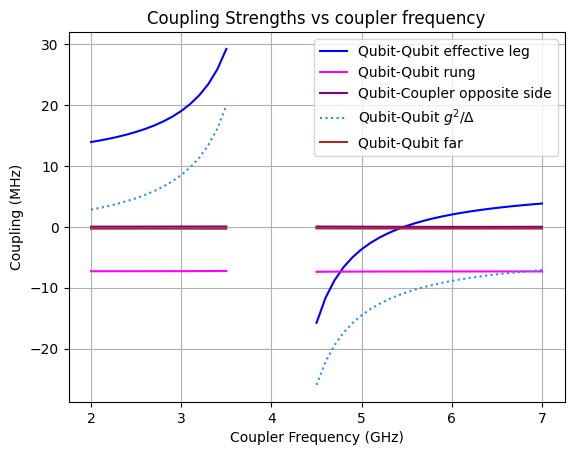

In [353]:
# plot data

# plt.plot(coupler_frequencies, g_qc_list/100, label='Qubit-Coupler bare (/100)')
plt.plot(coupler_frequencies[:num_lower_points], g_qq_leg_list[:num_lower_points], color='blue', label='Qubit-Qubit effective leg')
plt.plot(coupler_frequencies[num_lower_points:], g_qq_leg_list[num_lower_points:], color='blue')


plt.plot(coupler_frequencies[:num_lower_points], g_qq_rung_list[:num_lower_points], color='magenta', label='Qubit-Qubit rung')
plt.plot(coupler_frequencies[num_lower_points:], g_qq_rung_list[num_lower_points:], color='magenta')

plt.plot(coupler_frequencies[:num_lower_points], g_qc_far_list[:num_lower_points], color='purple', label='Qubit-Coupler opposite side')
plt.plot(coupler_frequencies[num_lower_points:], g_qc_far_list[num_lower_points:], color='purple')

plt.plot(coupler_frequencies[:num_lower_points], g_squared_over_delta_list[:num_lower_points], color='dodgerblue', linestyle=':', label='Qubit-Qubit $g^2/\Delta$')
plt.plot(coupler_frequencies[num_lower_points:], g_squared_over_delta_list[num_lower_points:], color='dodgerblue', linestyle=':',)

# plt.plot(coupler_frequencies[:num_lower_points], g_squared_over_delta_list2[:num_lower_points], color='cyan', linestyle=':', label='Qubit-Qubit $g^2/\Delta$ 2')
# plt.plot(coupler_frequencies[num_lower_points:], g_squared_over_delta_list2[num_lower_points:], color='dodgerblue', linestyle=':',)

if include_qq_far:
    plt.plot(coupler_frequencies[:num_lower_points], g_qq_far_list[:num_lower_points], color='brown', label='Qubit-Qubit far')
    plt.plot(coupler_frequencies[num_lower_points:], g_qq_far_list[num_lower_points:], color='brown')


plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.title('Coupling Strengths vs coupler frequency')
plt.grid()

plt.legend()
plt.show()

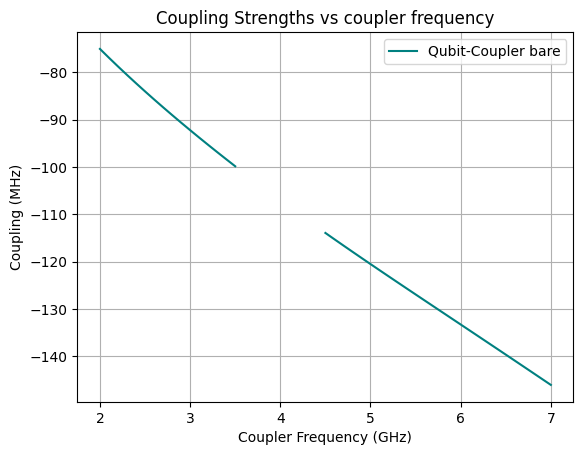

In [354]:
# plot data

plt.plot(coupler_frequencies[:num_lower_points], g_qc_list[:num_lower_points], color='teal', label='Qubit-Coupler bare')
plt.plot(coupler_frequencies[num_lower_points:], g_qc_list[num_lower_points:], color='teal')

# plt.plot(coupler_frequencies, g_qq_leg_list, label='Qubit-Qubit effective leg')
# plt.plot(coupler_frequencies, g_qq_rung_list, label='Qubit-Qubit rung')
# plt.plot(coupler_frequencies, g_qc_far_list, label='Qubit-Coupler opposite side')


plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.title('Coupling Strengths vs coupler frequency')
plt.grid()

plt.legend()
plt.show()

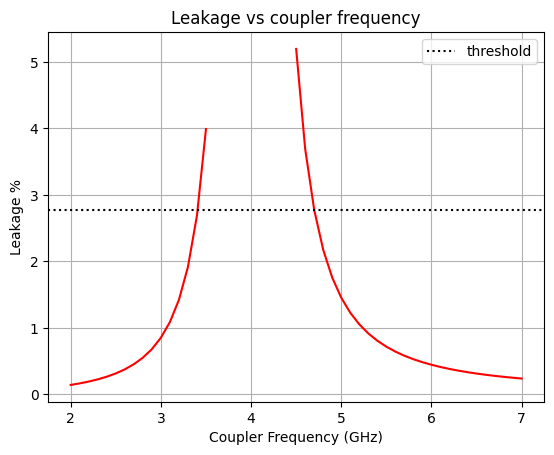

In [355]:
plt.plot(coupler_frequencies[:num_lower_points], leakage_list[:num_lower_points]*100, color='red')
plt.plot(coupler_frequencies[num_lower_points:], leakage_list[num_lower_points:]*100, color='red')

plt.axhline(100/36, linestyle=':', color='black', label='threshold')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Leakage %')

plt.grid()

plt.title('Leakage vs coupler frequency')
plt.legend()

plt.show()

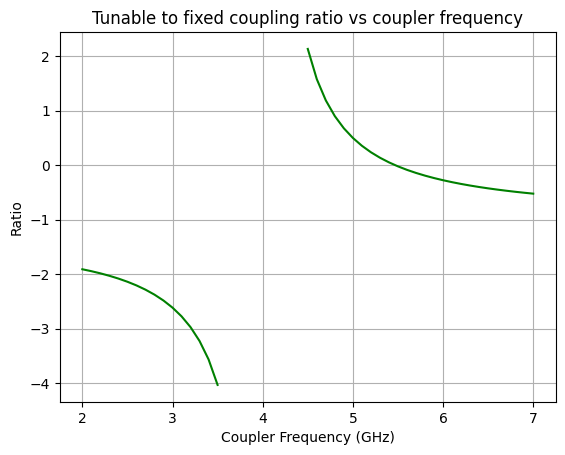

In [356]:
plt.plot(coupler_frequencies[:num_lower_points], tunable_to_fixed_ratio[:num_lower_points], color='green')
plt.plot(coupler_frequencies[num_lower_points:], tunable_to_fixed_ratio[num_lower_points:], color='green')

x0 = 5
a = -2
b = 1.5
fit_function_lambda = lambda x: a/(x-x0) + b
# plt.plot(coupler_frequencies[:num_lower_points], fit_function_lambda(coupler_frequencies[:num_lower_points]), color='blue')
# plt.plot(coupler_frequencies[num_lower_points:], fit_function_lambda(coupler_frequencies[num_lower_points:]), color='blue')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Ratio')

plt.grid()

plt.title('Tunable to fixed coupling ratio vs coupler frequency')

plt.show()

In [357]:
# EM_filename = 'EM_transmon_coupling 3'

print(f'{EM_filename}:\n')
print(f'Qubit frequency (GHz): {qubit_frequency}')
print(f'Qubit capacitance (fF): {np.round(C_q*1e15,2)}')
print(f'Coupler capacitance (fF): {np.round(C_c*1e15,2)}')

headers = ['Coupler frequency (GHz) -->', coupler_frequencies_lower[0], coupler_frequencies_lower[-1], coupler_frequencies_higher[0], coupler_frequencies_higher[-1]]

data_table = [headers]

t = Texttable()
t.header(headers)
t.add_row(['Qubit-Qubit effective coupling on leg (MHz)'] + get_four_points(g_qq_leg_list))
t.add_row(['Qubit-Qubit coupling along rung (MHz)'] + get_four_points(g_qq_rung_list))
t.add_row(['Qubit-Coupler bare coupling (MHz)'] + get_four_points(g_qc_list))
t.add_row(['Qubit-Coupler opposite sides coupling (MHz)'] + get_four_points(g_qc_far_list))

if include_qq_far:
    t.add_row(['Qubit-Qubit far (MHz)'] + get_four_points(g_qq_far_list))
    
t.add_row(['Qubit-Qubit g^2/Delta (MHz)'] + get_four_points(g_squared_over_delta_list))

t.add_row(['']*5)

t.add_row(['Leakage %'] + [val * 1e2 for val in get_four_points(leakage_list, 3)])
t.add_row(['Tunable (leg) to fixed (rung) coupling ratio'] + get_four_points(tunable_to_fixed_ratio))


# t.add_rows(data_table)

print(t.draw())

EM_transmon_coupling 3 2 1:

Qubit frequency (GHz): 4.0
Qubit capacitance (fF): 100.04
Coupler capacitance (fF): 78.76
+------------------------------------+---------+---------+----------+----------+
|    Coupler frequency (GHz) -->     |   2.0   |   3.5   |   4.5    |   7.0    |
+====================================+=========+=========+==========+==========+
| Qubit-Qubit effective coupling on  | 13.940  | 29.230  | -15.770  | 3.830    |
| leg (MHz)                          |         |         |          |          |
+------------------------------------+---------+---------+----------+----------+
| Qubit-Qubit coupling along rung    | -7.300  | -7.250  | -7.390   | -7.330   |
| (MHz)                              |         |         |          |          |
+------------------------------------+---------+---------+----------+----------+
| Qubit-Coupler bare coupling (MHz)  | -75.070 | -99.870 | -113.960 | -146.080 |
+------------------------------------+---------+---------+----------+--

In [358]:
# extrat name of EM Structure file

circuit_schematics_dict = project.circuit_schematics_dict


elements_dict = circuit_schematics_dict['transmon_coupling'].elements_dict

for name in elements_dict:
    break
    print(f'{name}: {elements_dict[name]}')
    if name == 'SUBCKT.S1':
        element = elements_dict[name]
        print(element.element_name)
        print(element.element_nodes_dict)
        for name in element.parameter_names_list:
            print(name)
        print()
        for name in element.parameters_dict:
            if name == 'NET':
                print(f'{name}: {parameter}')
                print('yes')
                print(parameter.value)
                print(parameter.value_str)
                print(parameter.__dict__)
                print(parameter._parameter)
                help(parameter)                


In [ ]:
def create_backup(file_name):
    # Define the backup folder
    backup_folder = "backups_8QV2"

    # Create the 'backups' folder if it doesn't exist
    if not os.path.exists(backup_folder):
        os.makedirs(backup_folder)

    # Get all files in the backup folder
    backup_files = os.listdir(backup_folder)

    # Find all backup files that match the naming pattern
    backup_files = [f for f in backup_files if f.startswith('qubit_tunable_coupling_8QV2_backup_') and f.endswith('.json')]

    # Determine the next backup number
    if backup_files:
        # Extract the numbers from the filenames, find the highest number, and increment it
        latest_backup_num = max([int(f.split('_')[-1].split('.')[0]) for f in backup_files])
        next_backup_num = latest_backup_num + 1
    else:
        next_backup_num = 1  # Start with 1 if no backups exist

    # Define the new backup file name
    backup_file_name = f"{backup_folder}/qubit_tunable_coupling_8QV2_backup_{next_backup_num}.json"

    # Copy the current JSON file to the new backup file
    shutil.copy(file_name, backup_file_name)
    print(f"Backup created: {backup_file_name}")


In [3]:
### read json data and add data from this sweep

json_filename = 'qubit_tunable_coupling_8QV2.json'


In [ ]:
### read in json data and add this sweep


json_data = None

with open(json_filename, 'r') as json_file:
    json_data = json.load(json_file)
    
    for i in json_data:
        print(i)
        
if json_data is None:
    raise RunetimeError('json data not initialized correctly')

create_backup(json_filename)
    
with open(json_filename, 'w') as json_file:
    
    qubit_key = f'qubit_frequency_{qubit_frequency}'

    # Ensure the qubit frequency exists in the data structure
    if qubit_key not in json_data:
        json_data[qubit_key] = {'coupler_sweep': {}}
    
    # Add the coupler frequency sweep data
    for i in range(len(coupler_frequencies)):
        
        
        coupler_sweep = {'coupler_frequency': coupler_frequencies[i],
                         'qubit_qubit_leg': g_qq_leg_list[i],
                         'qubit_qubit_rung': g_qq_rung_list[i],
                         'qubit_qubit_far': g_qq_far_list[i],
                         'qubit_coupler': g_qc_list[i],
                         'qubit_coupler_far': g_qc_far_list[i],
                         'leakage': leakage_list[i],
                         'tunable_to_fixed_ratio': tunable_to_fixed_ratio[i]}
    
        json_data[qubit_key]['coupler_sweep'][f'coupler_frequency_{coupler_frequencies[i]}'] = coupler_sweep
    
    json.dump(json_data, json_file)

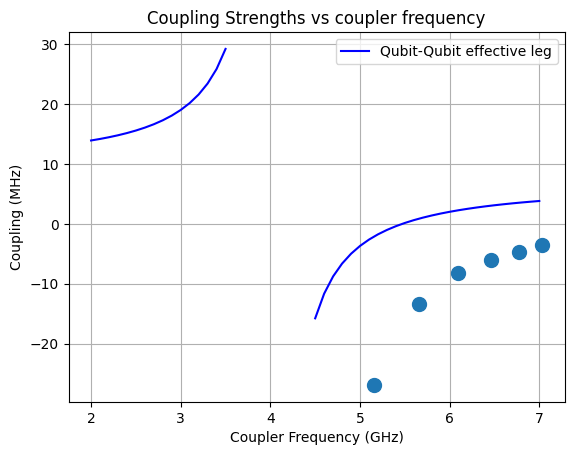

In [359]:
plt.plot(coupler_frequencies[:num_lower_points], g_qq_leg_list[:num_lower_points], color='blue', label='Qubit-Qubit effective leg')
plt.plot(coupler_frequencies[num_lower_points:], g_qq_leg_list[num_lower_points:], color='blue')

frequencies = [7.03, 6.77, 6.46, 6.09, 5.66, 5.16]
coupling_strengths = -np.array([3.46, 4.66, 6.02, 8.28, 13.3, 26.9])

plt.plot(frequencies, coupling_strengths, marker='o', ms=10, linestyle='')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.title('Coupling Strengths vs coupler frequency')
plt.grid()

plt.legend()
plt.show()

##### 